### Collaborative Filtering application - [notebook](https://github.com/fastai/fastbook/blob/master/08_collab.ipynb)

**Todos**
*   Remove split_param = random from the Data Bundle, after making that the default in data_lib

### Import KD Libraries

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import IPython.core.debugger as db
from pathlib import Path
import pandas as pd
import torch
from torch import nn

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
gd_path = 'gdrive/My Drive/Colab Data/fastai-v3'  #change dir to your project folder
gn_path = 'gdrive/My Drive/Colab Notebooks'  #change dir to your project folder

import sys
sys.path.insert(1, gn_path + '/exp')

In [5]:
from nb_util import save_pickle, load_pickle, DebugRand
from nb_data import TabularDataBundle, FeatureSet, FeatureList
from nb_app import AppBase, ArchTabular, AppTabular

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Bundle

In [6]:
#----------------------------------------------------
# Movielens Collaborative Filtering data preparation pipeline
#----------------------------------------------------
class TabularMovielensDataBundle(TabularDataBundle):
  def __init__(self, csv_path, test_csv_path, related_csv_paths, **kwargs):
    super().__init__(csv_path, test_csv_path, related_csv_paths, prepare_fn=self.prepare)
    split_params = {'split_procedure': 'split_random', 'train_ratio': 0.8, 'valid_ratio': 0.2}

  # ----------------------------
  # Basic training columns
  # ----------------------------   
  def _prepare_base(self, il):
    # Merge the 'movies' into main
    il.join_df(right_df_name='movies', left_on='movieId')

    # !!!!!!!!!
    #base_cat_cols = ['userId', 'movieId', 'title']
    base_cat_cols = ['userId', 'title']
    base_cont_cols = []

    fs = FeatureSet('base', base_cat_cols, base_cont_cols)
    return (fs)

  # ----------------------------
  # Target columns
  # ----------------------------   
  def _prepare_tgt(self, il):
    cols_tgt=['rating']
    self.tgt_range = (0, 5.5)      
    return cols_tgt

  # ----------------------------
  # Prepare and pre-process the data
  # ----------------------------   
  def prepare(self, il, is_test=False):
    fl = FeatureList()
    fs = self._prepare_base(il)
    fl.add_fs(fs)

    cols_tgt = self._prepare_tgt(il)

    il = super().prepare(il, fl, cols_tgt)
    return il


### Define data paths

In [7]:
app_dir='movielens'

root_path = Path.cwd()
download_path = root_path/app_dir
data_path = download_path

main_file_path = data_path/'ratings.csv'
related_csv_paths = [data_path/'movies.csv']

pickle_dir = root_path/'pickle'

### Download data

In [8]:
def movielens_download(download_file_name, out_path):
  zip_file = f'{download_file_name}.zip'
  !wget http://files.grouplens.org/datasets/movielens/{zip_file}

  !zipinfo {zip_file}
  !unzip {zip_file} >> /dev/null
  !mv {download_file_name} {out_path}
  !ls -l {out_path}

#download_file_name='ml-latest-small'
download_file_name='ml-100k'
movielens_download(download_file_name, data_path)

--2020-09-11 12:33:29--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  3.51MB/s    in 1.3s    

2020-09-11 12:33:31 (3.51 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
Zip file size: 4924029 bytes, number of entries: 24
drwxr-x---  3.0 unx        0 bx stor 16-Jan-29 20:26 ml-100k/
-rwxr-x---  3.0 unx      716 tx defX 00-Jul-19 21:09 ml-100k/allbut.pl
-rwxr-x---  3.0 unx      643 tx defX 00-Jul-19 21:09 ml-100k/mku.sh
-rw-r-----  3.0 unx     6750 tx defX 16-Jan-29 20:26 ml-100k/README
-rw-r-----  3.0 unx  1979173 tx defX 00-Jul-19 21:09 ml-100k/u.data
-rw-r-----  3.0 unx      202 tx defX 00-Jul-19 21:09 ml-100k/u.genre
-rw-r-----

In [9]:
# Pre-process data and convert it to CSV format
ratings_df = pd.read_csv(data_path/'u.data', delimiter='\t', header=None, names=['userId','movieId','rating','timestamp'])
movies_df = pd.read_csv(data_path/'u.item',  delimiter='|', encoding='latin-1', usecols=(0,1), names=('movieId','title'), header=None)
ratings_df.to_csv(main_file_path, index=False)
movies_df.to_csv(related_csv_paths[0], index=False)

### Exploratory Data Analysis

In [10]:
mldb = TabularDataBundle(main_file_path, related_csv_paths=related_csv_paths)
train_il = mldb.process(steps=['load'])

--------- Tabular Home Credit DataBundle init /content/movielens/ratings.csv None [PosixPath('/content/movielens/movies.csv')]
/content/movielens/movies.csv memory reduced by 37.3% from 0.03 MB to 0.02 MB
/content/movielens/ratings.csv memory reduced by 71.9% from 3.05 MB to 0.86 MB
DfItemList init with 100000 items, 0.86 df memory, 0.86 items memory
CSVItemContainer loaded 100000 items of type TabularItemList


In [11]:
train_il.df.sample()
train_il.movies_df.sample()

,userId,movieId,rating,timestamp
97175,790,176,3,885155489


,movieId,title
1350,1351,Lover's Knot (1996)


### Build Collaborative Filtering Architecture

In [67]:
#----------------------------------------------------
# Dot Product module
#----------------------------------------------------
class DotProductBias(nn.Module):
  def __init__(self, n_users, n_movies, n_factors, y_range):
    super().__init__()
    # User Embedding with Bias
    self.user_factors = nn.Embedding(n_users, n_factors)
    self.user_bias = nn.Embedding(n_users, 1)

    # Movie Embedding with Bias
    self.movie_factors = nn.Embedding(n_movies, n_factors)
    self.movie_bias = nn.Embedding(n_movies, 1)

    # Range of y values
    self.y_range = y_range
        
  def forward(self, x):
    # Get the user and movie ID
    user, movie = x[:,0].long(), x[:,1].long()

    # Get the user and movie embedding vectors
    users = self.user_factors(user)
    movies = self.movie_factors(movie)

    # Compute dot product and add user and movie bias
    res = (users * movies).sum(dim=1, keepdim=True)
    res += self.user_bias(user) + self.movie_bias(movie)

    # Restrict output values to desired y value range
    if (self.y_range):
      res = self.y_range[0] + torch.sigmoid(res) * (self.y_range[1] - self.y_range[0])
    return res

#----------------------------------------------------
# Hybrid architecture module
#----------------------------------------------------
class HybridCF(nn.Module):
  def __init__(self, neuralcf, dotproduct, out_sz, y_range):
    super().__init__()
    self.neuralcf = neuralcf
    self.dotproduct = dotproduct
    self.lin = nn.Linear(2, out_sz)

    # Range of y values
    self.y_range = y_range
        
  def forward(self, x):
    x_dp = self.dotproduct(x)
    x_ncf = self.neuralcf(x)
    x = torch.cat([x_dp, x_ncf], dim=1)
    x = self.lin(x)
    x = self.y_range[0] + torch.sigmoid(x) * (self.y_range[1] - self.y_range[0])
    return x

In [64]:
#----------------------------------------------------
# Create the Collaborative Filtering architecture
#----------------------------------------------------
class ArchCollabFilter(ArchTabular):
  def __init__(self, arch_type):
    assert(arch_type in ['neuralcf', 'dotproduct', 'hybrid'])

    super().__init__()
    self.arch_type = arch_type

  # ----------------------------
  # Create one of three models:
  #   1. Neural Network Collaborative Filtering model (NCF)
  #   2. Dot Product model
  #   3. Hybrid model with combined NCF and Dot Product
  # ----------------------------
  def create_model(self, cat_szs, n_cont, emb_p, hidden_szs, hidden_ps, out_sz, out_range):
    if (self.arch_type == 'neuralcf'):
      super().create_model(cat_szs, n_cont, emb_p, hidden_szs, hidden_ps, out_sz=out_sz, out_range=out_range)
    elif (self.arch_type == 'dotproduct'):
      self.create_dotproduct(cat_szs, out_range)
    elif (self.arch_type == 'hybrid'):
      self.create_hybrid(cat_szs, n_cont, emb_p, hidden_szs, hidden_ps, out_sz=out_sz, out_range=out_range)

  # ----------------------------
  # Dot Product (aka Matrix Factorisation model)
  # ----------------------------
  def create_dotproduct(self, cat_szs, out_range):
    n_users, n_movies = cat_szs[0], cat_szs[1]
    self.model = DotProductBias(n_users, n_movies, 50, y_range=out_range)

  # ----------------------------
  # ----------------------------
  def create_hybrid(self, cat_szs, n_cont, emb_p, hidden_szs, hidden_ps, out_sz, out_range):
    super().create_model(cat_szs, n_cont, emb_p, hidden_szs, hidden_ps, out_sz=out_sz, out_range=None)
    self.neuralcf = self.model
    self.create_dotproduct(cat_szs, out_range=None)
    self.dotproduct = self.model
    self.model = HybridCF(self.neuralcf, self.dotproduct, out_sz=out_sz, y_range=out_range)


### Define Collaborative Filtering application class

In [61]:
#----------------------------------------------------
# Collaborative Filtering Application
#----------------------------------------------------
class AppCollabFilter(AppTabular):
  def __init__(self):
    super().__init__(loss_type='regression', metrics_cbs=[])

  # ----------------------------
  # Create the architecture
  # ----------------------------
  def create_arch(self, arch_type='neuralcf', emb_p=0.04, hidden_szs=[100, 50], hidden_ps=[.001, .01]):
    self._arch = ArchCollabFilter(arch_type)
    self._arch.create_model(self.cat_szs, self.n_cont, 
                            emb_p=emb_p, hidden_szs=hidden_szs, hidden_ps=hidden_ps, 
                            out_sz=self.n_tgt, out_range=self.tgt_range)
    return self._arch


### Load Data

In [22]:
cf_app = AppCollabFilter()
cf_app.load_data(TabularMovielensDataBundle, main_file_path, test_file_path=None, related_csv_paths=related_csv_paths, steps=['load'])
save_pickle(cf_app, pickle_dir, 'prep_data.pkl')

--------- Tabular Home Credit DataBundle init /content/movielens/ratings.csv None [PosixPath('/content/movielens/movies.csv')]
/content/movielens/movies.csv memory reduced by 37.3% from 0.03 MB to 0.02 MB
/content/movielens/ratings.csv memory reduced by 71.9% from 3.05 MB to 0.86 MB
DfItemList init with 100000 items, 0.86 df memory, 0.86 items memory
DfItemList init with 100000 items, 0.61 df memory, 0.86 items memory
CSVItemContainer loaded 100000 items of type TabularItemList


In [23]:
cf_app = load_pickle(pickle_dir/'prep_data.pkl')
cf_app.load_data(None, None, None, None, steps=['post_load'])
save_pickle(cf_app, pickle_dir, 'proc_data.pkl')

DfItemList init with 80000 items, 0.52 df memory, 0.69 items memory
DfItemList init with 20000 items, 0.23 df memory, 0.17 items memory
Split using split_sequential into 80000, 20000 and 0 items of type TabularItemList
DfItemList init with 80000 items, 0.44 df memory, 0.69 items memory
Extracted 80000 items of type TabularItemList using extract_type
DfItemList init with 80000 items, 0.08 df memory, 0.69 items memory
Extracted 80000 items of type TabularItemList using extract_type
Converted 80000 items to type TabularItemList using remove_inf
Converted 80000 items to type TabularItemList using check_missing
Converted 80000 items to type TabularItemList using fill_missing
Converted 80000 items to type TabularItemList using normalise
Converted 80000 items to type TabularItemList using to_cat
Converted 80000 items to type TabularItemList using to_np
Converted 80000 items to type TabularItemList using to_np
DfItemList init with 20000 items, 0.21 df memory, 0.17 items memory
Extracted 20000 

gdrive/My Drive/Colab Notebooks/exp/nb_data.py:2968: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if (not np.issubdtype(arr.dtype, float)):


### Train model

In [117]:
arch_type = 'neuralcf'
#arch_type = 'dotproduct'
#arch_type = 'hybrid'
if (arch_type == 'neuralcf'):
  weight_decay = 0.1
  lr = 5e-3
elif (arch_type == 'dotproduct'):
  weight_decay = 0.2
  lr = 9e-3
elif (arch_type == 'hybrid'):
  weight_decay = 0.2
  lr = 15e-3

In [118]:
DebugRand.set_seed(0)
cf_app = load_pickle(pickle_dir/'proc_data.pkl')

cf_app.create_arch(arch_type=arch_type, emb_p=0.04, hidden_szs=[100, 50], hidden_ps=[.001, .01])
cf_app._arch.save_weights(pickle_dir/'arch_init_wgts.mdl')
cf_app._arch.load_weights(pickle_dir/'arch_init_wgts.mdl')

cf_app.create_debug(use_dtr=True, track_batches_per_epoch=15, disp_tb=False, disp_pd=True, debug_bkwd=False, debug_fwd=False, abort_iter=0)

In [107]:
find_lr = True
if (find_lr):
  loop = cf_app.lr_find(start_lr=1e-7, end_lr=10, num_iter=100, weight_decay=weight_decay)

In [119]:
loop = cf_app.run_train(num_epochs=5, split_lr=[lr], weight_decay=weight_decay, one_cycle=True)

epoch,tr_loss,smooth_loss,val_loss,time
0,1.242404,1.025441,1.042371,00:09
1,0.973798,0.971738,0.925130,00:09
2,0.903192,0.868750,0.881739,00:09
3,0.855390,0.851165,0.860565,00:09
4,0.798046,0.798292,0.861937,00:09


### Display Metrics

(None, None)

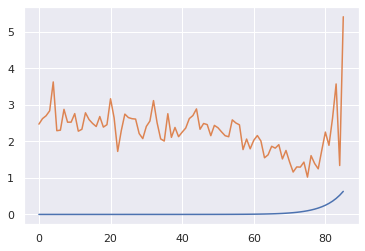

In [108]:
recorder=loop.cbs[1]
recorder.plot_lr(), recorder.plot_loss()

In [ ]:
is_run_df, is_batch_df, is_layer_df, _ = loop.dtr.pd_results()
is_run_df
is_batch_df.head(2)
is_layer_df.head(2)

,run_id,num_epochs,row_type,epoch_id,num_tr_batches,num_val_batches,tr_loss,smooth_loss,val_loss,time
0,Run-20200826_085649,10.0,run,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Run-20200826_085649,NaN,epoch,0.0,1250.0,313.0,1.401455,1.110866,1.091659,00:09
32,Run-20200826_085649,NaN,epoch,1.0,1250.0,313.0,1.035236,0.972608,0.986432,00:09
63,Run-20200826_085649,NaN,epoch,2.0,1250.0,313.0,0.940449,0.940572,0.906763,00:09
94,Run-20200826_085649,NaN,epoch,3.0,1250.0,313.0,0.908960,0.913317,0.903817,00:09
125,Run-20200826_085649,NaN,epoch,4.0,1250.0,313.0,0.888944,0.917525,0.886085,00:09
156,Run-20200826_085649,NaN,epoch,5.0,1250.0,313.0,0.868609,0.881667,0.877466,00:09
187,Run-20200826_085649,NaN,epoch,6.0,1250.0,313.0,0.830558,0.833033,0.850083,00:09
218,Run-20200826_085649,NaN,epoch,7.0,1250.0,313.0,0.778473,0.781861,0.843941,00:09
249,Run-20200826_085649,NaN,epoch,8.0,1250.0,313.0,0.720056,0.725629,0.860901,00:09


,run_id,row_type,epoch_id,batch_id,iter,batch_type,pred,loss,lr,mom,betas_2,eps,weight_decay,amsgrad
2,Run-20200826_085649,batch,0.0,0-0,0.0,train,2.559273,2.636589,0.0002,0.95,0.99,1.000000e-08,0.1,False
3,Run-20200826_085649,batch,0.0,0-1,1.0,train,2.563068,2.492674,0.0002,0.95,0.99,1.000000e-08,0.1,False


""


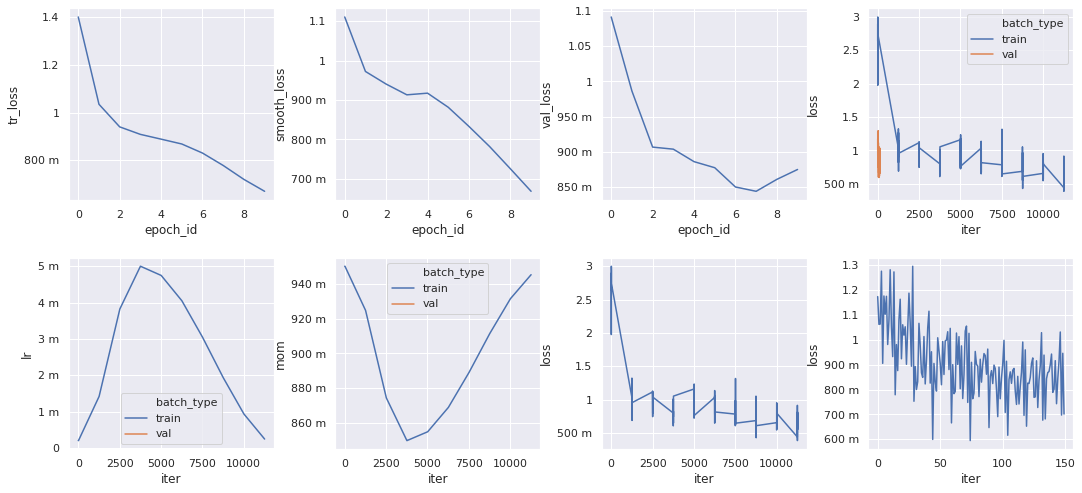

In [ ]:
loop.dtr.pd.display_metrics(is_run_df, is_batch_df, app_metrics=[])

### Results

In [ ]:
## Neural Collab Filter ##
epoch	tr_loss	smooth_loss	val_loss	time
0	1.401455	1.110866	1.091659	00:09
1	1.035236	0.972608	0.986432	00:09
2	0.940449	0.940572	0.906763	00:09
3	0.908960	0.913317	0.903817	00:09
4	0.888944	0.917525	0.886085	00:09
5	0.868609	0.881667	0.877466	00:09
6	0.830558	0.833033	0.850083	00:09
7	0.778473	0.781861	0.843941	00:09
8	0.720056	0.725629	0.860901	00:09
9	0.670122	0.668454	0.874954	00:09

epoch	tr_loss	smooth_loss	val_loss	time
0	1.242404	1.025441	1.042371	00:09
1	0.973798	0.971738	0.925130	00:09
2	0.903192	0.868750	0.881739	00:09
3	0.855390	0.851165	0.860565	00:09
4	0.798046	0.798292	0.861937	00:09

## Dot Product ##
epoch	tr_loss	smooth_loss	val_loss	time
0	6.760159	3.977214	3.565830	00:05
1	1.272357	0.929969	0.929410	00:05
2	0.847172	0.876026	0.889313	00:05
3	0.744167	0.752628	0.842579	00:05
4	0.616866	0.635537	0.838496	00:05

## Hybrid ##
epoch	tr_loss	smooth_loss	val_loss	time
0	1.287812	0.998535	0.989868	00:11
1	0.990646	0.991299	0.996781	00:11
2	0.922978	0.930865	0.919929	00:11
3	0.815948	0.803662	0.853280	00:11
4	0.557079	0.553237	0.836735	00:11